Big Tips: To hide/unhide code, click on the rightmost icon on the top icon set.

Download the data [here](https://www.kaggle.com/c/kaggle-survey-2019/data) in case you want to run this notebook.

Tips on interacting with the charts:

(Stacked) bar chart:
- Double click on legend item to isolate it
- Single click on legend item to hide it
- Pro tip: If you want to isolate a few of many variables, start by double clicking any one of them and add the rest by single clicking them

Treemap:
- The only way to interact is by clicking the box of your desired level of detail and to revert back to high-level view, you can click one of the arrows on the top (it only appears when you're NOT on the topmost level).

Tips on tinkering with the code:
- Each function I created is highly customizable (at least to me). The arguments (the one preceding '=' each time you call a function) are pretty self-explanatory. In case you don't know what arguments a particular function can take, just type help(function_name).

Some weird argument names and its explanations:

- var (in plot_treemap and plot_treemap_mc_two_var): this takes a list. let me explain by example. If you want to plot job title vs gender, 'var' will be ['Q5', 'Q2']
- country_level -> by default set to false. if set to true, the lowest level (before the variable) will be the countries instead of sub-regions
- inc_scale -> increasing scale, by default set to false. if color value is set to variable, by default the colors will be discrete. if you're dealing with variable with categories which can be put on a scale, you can set this to true so that the color will reflect that scale (it's done by representing each category with 0, 1, 2, ..., yeah it's simplistic I know, but works for most purposes)
- color_scale -> you can change it to built-in colorscales in plotly, but thermal is the best one I think.
- filt -> filter. let me explain how to use it by example. if you want to filter out only the data scientists and data analysts (Q5 is column name for that question), this is how you do it.

         filt = {Q5: ['Data Scientist', 'Data Analyst]}
     
- custom_map -> this is closely related to inc_scale argument above. generally, you don't want to enable ONLY inc_scale because it asssumes that the categories are already sorted, which they're often not. This argument takes a dictionary that maps 0, 1, 2, .. to the categories that you have sorted manually. Example of usage:

        q4 = merge['Q4'].unique()
        order = [5, -2, 2, 3, 1, 0, 4]
        map_ = {q4[j]: i for i, j in enumerate(order)}
    
What I did was map each education category to an integer after sorting it. So 5, the first element of the 'order' list, it must stand for 'Unspecified Education' and it will be represented as 0, and so on.

- color_col_name -> by default, the var name on the hovered data will be the column name you specify in 'color' argument, which is ugly. So if you put 'Q5' as 'color', you can display it as 'job title' by specifying it in this argument

Here is some utility function I've created:
- q_ (a dictionary really) -> displaying the list of questions. if you want to know the column name for gender, use the function, and the column name is Q + the question number for that question.
- is_mc(question_column_name) -> returns False if the question only takes one choice and returns all the column names if the question is a multiple choice one
- options('question_column_name') -> returns all the options for the multiple choice question (e.g. for cloud computing (Q29), it returns AWS, Google Cloud, Azure)

In [21]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
import plotly.io as plt_io
from plotly.subplots import make_subplots
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import seaborn as sns
import matplotlib.pyplot as plt
plt_io.templates["custom_dark"] = plt_io.templates["plotly_dark"]
plt_io.templates["custom_dark"]['layout']['paper_bgcolor'] = '#30404D'
plt_io.templates["custom_dark"]['layout']['plot_bgcolor'] = '#30404D'
plt_io.templates['custom_dark']['layout']['yaxis']['gridcolor'] = '#4f687d'
plt_io.templates['custom_dark']['layout']['xaxis']['gridcolor'] = '#4f687d'

api_key = 'gEcq2L8QDTvCxLQsXaUb'
username = 'emperor22'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
chart_studio.tools.set_config_file(world_readable=True, sharing='public')

In [22]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

In [23]:
mc = pd.read_csv('multiple_choice_responses.csv')
txt = pd.read_csv('other_text_responses.csv')
qtns = pd.read_csv('questions_only.csv')
schema = pd.read_csv('survey_schema.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning:

Columns (0,3,7,19,34,47,49,50,51,52,53,54,68,81,94,96,109,115,130,139,147,154,167,180,193,206,219,232,245) have mixed types.Specify dtype option on import or set low_memory=False.



In [24]:
q = qtns.transpose()
q_ = {i:j for i, j in enumerate(q[0].unique())}

In [25]:
continent = pd.read_csv('country_code_continent.csv')
continent.rename(columns={'name': 'country', 'alpha-3': 'code'}, inplace=True)
#continent.rename(columns={'alpha-3': 'code'}, inplace=True)
#reg = pd.merge(mc, continent, on='code')[['country', 'code', 'region']]

In [26]:
# Synchronizing countries' name before merging to obtain country code

c_replace = {'Korea, Republic of': 'South Korea',
             'Hong Kong': 'Hong Kong (S.A.R.)', 
             "Korea (Democratic People's Republic of)": 'Republic of Korea', 
             "Iran (Islamic Republic of)": 'Iran, Islamic Republic of...', 
             "Czechia": "Czech Republic",
             "Russian Federation": "Russia",
             "Taiwan, Province of China": "Taiwan"
            }

for i, j in c_replace.items():
    continent.loc[continent['country'] == i, 'country'] = j

In [27]:
c_count = mc['Q3'].value_counts().reset_index()
c_count.columns = ['country', 'count']
c_count_ = pd.merge(c_count, continent[['country', 'code', 'region', 'sub-region']], on='country')

In [28]:
fig = go.Figure(data=(go.Choropleth(z=c_count['count'],
                                    locations=c_count_['code'],
                                    text=c_count_['country'],
                                    colorscale='thermal',
                                    autocolorscale=False)))
fig.update_layout(title_text='Responder Counts by Country',
                  template='plotly_dark',
                  geo=dict(showframe=False,
                           showcoastlines=False,
                           projection_type='equirectangular'))
iplot(fig)

I decided that analyses will be done in aggregate level and in region (continental) level. Most countries have respondents below 300 and only India and the US have number of respondents above one thousand.

Most of all, I wanted to answer many questions regarding data-related practices and jobs in Indonesia (since that's where I live) but the number of respondents is shockingly small. Nevertheless, we'll try to dissect that small number of data points and reveal meaningful insights from it.

Let's see what professions made up the responses.

In [29]:
merge = pd.merge(mc.rename(columns={'Q3': 'country'}), continent[['country', 'code', 'region', 'sub-region']], on='country')
merge.sort_values(by='region', inplace=True)
merge.rename(columns={'Time from Start to Finish (seconds)': 'Q0'}, inplace=True)

### Time spent completing the surveys

Text(0.5, 1.0, 'Time spent completing the surveys (Hours)')

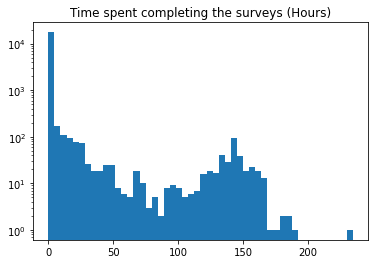

In [30]:
plt.hist(merge['Q0'].astype('int').apply(lambda x: x/3600), bins=50)
plt.yscale('log')
plt.title('Time spent completing the surveys (Hours)')

 # Univariate analysis by sub-region

In [31]:
def options(var):
    col = [i for i in mc.columns if var + '_Part_' in i]
    for i in col:
        a = [mc.iloc[1:][i].loc[mc[i].notna()].unique()[0]]
        print(a)

In [32]:
def is_mc(var):
    lst = [i for i in merge.columns if var + '_Part' in i]
    if lst:
        col = [i for i in mc.columns if var + '_Part' in i]
        return col
    else:
        return False

In [33]:
def plot_stacked_bar(var,
                     title='',
                     showlegend=True,
                     showxaxis=False,
                     add_width=0,
                     add_height=0):
    tmp = merge.copy()
    tmp = tmp.dropna(subset=[var])
    cols = sorted(list(tmp[var].unique())) + ['sub-region']
    df = pd.DataFrame(columns=cols)
    df_ = pd.DataFrame(columns=cols)
    for i in list(tmp['sub-region'].unique()) + ['World']:
        wa = tmp.loc[(tmp['sub-region'] == i)][var].value_counts(
            normalize=True).sort_index().transpose()
        wa_ = tmp.loc[(tmp['sub-region'] == i
                       )][var].value_counts().sort_index().transpose()
        if i == 'World':
            wa = tmp[var].value_counts(normalize=True).sort_index().transpose()
            wa_ = tmp[var].value_counts().sort_index().transpose()
        wa = wa.apply(lambda x: round(x * 100, 2))
        wa['sub-region'] = i
        wa_['sub-region'] = i
        df = df.append(wa)
        df_ = df_.append(wa_)

    data = []
    for i in df.columns[:-1]:
        data.append(
            go.Bar(
                y=df['sub-region'],
                x=df[i],
                name=i,
                orientation='h',
                customdata=np.stack((df[i], df_[i]), axis=1),
                hovertemplate=
                'Counts: %{customdata[1]}<br>Percentage: %{customdata[0]}%'))

    fig = go.Figure(data=data)
    fig.update_layout(barmode='stack',
                      title_text=title,
                      xaxis=go.layout.XAxis(showticklabels=showxaxis),
                      width=800 + add_width,
                      height=500 + add_height,
                      template='custom_dark',
                      showlegend=showlegend)
    return fig

In [34]:
def plot_stacked_bar_mc(var,
                        title='',
                        showlegend=True,
                        showxaxis=False,
                        add_width=0,
                        add_height=0):
    tmp = merge.copy()
    col = [i for i in mc.columns if var + '_Part_' in i]
    opt = [mc.iloc[1:][i].loc[mc[i].notna()].unique()[0] for i in col]

    df = pd.DataFrame(columns=opt + ['sub-region'])

    for i in list(tmp['sub-region'].unique()) + ['World']:

        count = {}
        count['sub-region'] = [i]
        tmp_ = tmp if i == 'World' else tmp.loc[tmp['sub-region'] == i]
        for a, b in zip(col, opt):
            if tmp_[a].nunique() == 0:
                count[b] = [0]
            else:
                count[b] = [tmp_.loc[tmp_[a] == b].shape[0]]
        counts = pd.DataFrame(count)
        df = df.append(counts)
    df = df.set_index('sub-region')
    df_ = df.div(df.sum(axis=1), axis=0).applymap(lambda x: x * 100)

    data = []
    for i in df.columns:
        data.append(
            go.Bar(
                y=df_.index,
                x=df_[i],
                orientation='h',
                name=i,
                customdata=np.stack((df[i], df_[i]), axis=1),
                hovertemplate=
                'Counts: %{customdata[0]}<br>Percentage: %{customdata[1]:.2f}%'
            ))

    fig = go.Figure(data=data)
    fig.update_layout(barmode='stack',
                      title_text=title,
                      xaxis=go.layout.XAxis(showticklabels=showxaxis),
                      width=800 + add_width,
                      height=500 + add_height,
                      template='custom_dark',
                      showlegend=showlegend)

    return fig

In [35]:
plot_stacked_bar('Q1', 'Responders by age group')

In [36]:
plot_stacked_bar('Q2', 'Responders by gender')

In [37]:
plot_stacked_bar('Q4', 'Responders by education', add_width=300)

In [38]:
plot_stacked_bar('Q5', 'Responders by job title', add_width=100)

In [39]:
plot_stacked_bar('Q6', 'Responders by company size')

In [40]:
plot_stacked_bar('Q8', 'Responders by whether their employer implements ML', False)

In [41]:
plot_stacked_bar_mc('Q9', 'Responders by activities at work', False)

In [42]:
plot_stacked_bar('Q10', 'Responders by compensation', showxaxis=True)

This chart is way too crowded, but it still can provide you information. Isolate any salary group that you want by double clicking it and add more by clicking other salary groups that interest you.

Say you want to work in other parts of the world and are expecting some amount of compensation e.g. USD 30000 - 80000, what you should do is double click ANY of salary range within your desired range and then add others by (single) clicking them.

In [43]:
plot_stacked_bar_mc('Q12', 'Responders by favorite ML media', add_width=300, showxaxis=True)

In [44]:
plot_stacked_bar_mc('Q13', 'Responders by ML learning platforms used', add_width=200, showxaxis=True)

In [45]:
plot_stacked_bar('Q14', 'Responders by tools to analyze data', add_width=300)

In [46]:
plot_stacked_bar('Q15', "Responders by how long they've been coding to analyze data")

In [47]:
plot_stacked_bar_mc('Q16','Responders by IDEs used' ,add_width=200, showxaxis=True)

In [48]:
plot_stacked_bar_mc('Q18', 'Responders by programming languages used')

In [49]:
plot_stacked_bar_mc('Q20', 'Responders by data visualization tools used')

In [50]:
plot_stacked_bar('Q23', 'Responders by years of using ML')

In [51]:
plot_stacked_bar_mc('Q24', 'Responders by ML algorithms used', add_width=200, showxaxis=True)

The majority of ML practitioners still use classical ML algorithms (blue, red, green bars). That makes sense since most use cases still prioritize interpretability over predictive power. Moreover, most firms don't have the amount of data and the resources that will justify the use and/or the development of deep learning models.

In [52]:
plot_stacked_bar_mc('Q28', 'Responders by ML frameworks used')

In [53]:
plot_stacked_bar_mc('Q34', 'Responders by RDBMS used', add_width=100)

In [54]:
plot_stacked_bar_mc('Q31', 'Responders by Big Data frameworks used', add_width=100)

# Bivariate analysis

### Here is where the most interesting questions get answered

Note: I'm mostly only interested in ML practitioners and jobs that MIGHT require ML use. So for most of the graphs below, this filter will be used:

    filt = {'Q5': ['Data Scientist', 'Data Analyst', 'Data Engineer', 'Research Scientist', 'Business Analyst', 
                   'Statistician']}

In [55]:
def plot_subregion_two_vars(subregion,
                            var1,
                            var2,
                            title,
                            vertical=False,
                            add_width=0,
                            add_height=0):
    tmp = merge.copy()
    cols = list(tmp[var2].unique()) + ['var']
    df = pd.DataFrame(columns=cols)
    df_ = pd.DataFrame(columns=cols)
    data_h = []
    data_v = []
    for i in tmp[var1].unique():
        grp = tmp.loc[(tmp['sub-region'] == subregion) & (tmp[var1] == i),
                      var2].value_counts(normalize=True).transpose()
        grp_ = tmp.loc[(tmp['sub-region'] == subregion) & (tmp[var1] == i),
                       var2].value_counts().transpose()
        if subregion == 'World':
            grp = tmp.loc[tmp[var1] == i, var2].value_counts(normalize=True)
            grp_ = tmp.loc[tmp[var1] == i, var2].value_counts()
        grp = grp.apply(lambda x: round(x * 100, 2))
        grp['var'] = i
        grp_['var'] = i
        df = df.append(grp)
        df_ = df_.append(grp_)

    for i in df.columns[:-1]:
        data_h.append(
            go.Bar(
                y=df['var'],
                x=df[i],
                name=i,
                orientation='h',
                customdata=np.stack((df[i], df_[i]), axis=1),
                hovertemplate=
                'Counts: %{customdata[1]}<br>Percentage: %{customdata[0]}%'))
        data_v.append(
            go.Bar(
                x=df['var'],
                y=df[i],
                name=i,
                customdata=np.stack((df[i], df_[i]), axis=1),
                hovertemplate=
                'Counts: %{customdata[1]}<br>Percentage: %{customdata[0]}%'))

    data = data_v if vertical else data_h
    fig = go.Figure(data=data)

    fig.update_layout(barmode='stack',
                      title_text=f'Responders in {subregion}: {title}',
                      xaxis=go.layout.XAxis(showticklabels=False),
                      width=800 + add_width,
                      height=500 + add_height,
                      template='custom_dark')
    if vertical:
        fig.update_layout(xaxis=go.layout.XAxis(showticklabels=True),
                          yaxis=go.layout.YAxis(showticklabels=False))

    return fig

In [56]:
def plot_treemap(var,
                 title='',
                 country_level=False,
                 color=None,
                 inc_scale=False,
                 colorscale='thermal',
                 filt=None,
                 custom_map=None,
                 color_col_name=None,
                 template='custom_dark'):

    tmp = merge.copy()
    tmp = tmp.loc[tmp.Q5.isin([
        'Data Scientist', 'Data Analyst', 'Data Engineer',
        'Research Scientist', 'Business Analyst', 'Statistician'
    ])]
    lowest_level = ['sub-region'
                    ] if not country_level else ['sub-region', 'country']
    path = lowest_level + var
    path_ = path

    # making sure that the grouped df have color column but not include it in the treemap path
    # hence the creation of 'path_' variable: var. 'path_' is for grouping and can be modified later
    # and var. 'path' is for the treemap path

    if color is not None and color not in path:
        path_ = path + [color]

    if custom_map is not None:
        inc_scale = True

    # chained conditionals to accommodate multiple forms of filter
    df = tmp

    if filt is not None:
        col = list(filt.keys())[0]
        value = filt[list(filt.keys())[0]]
        if isinstance(value,
                      list):  # for multiple values for a col isin() is used
            df = tmp.loc[tmp[col].isin(value)]
        else:
            df = tmp.loc[tmp[col] == value]

        # only for multiple column filters with single values
        # from https://stackoverflow.com/questions/34157811/filter-a-pandas-dataframe-using-values-from-a-dict
        if len(filt) > 1:
            df = tmp.loc[(df[list(filt)] == pd.Series(filt)).all(axis=1)]

    # grouping to get count values and converting it to a df
    grp = df.groupby(path_).size().to_frame(name='count').reset_index()

    # creating a color col and mapping it to an integer (assuming the col's values are properly sorted)
    if color is not None:
        # by default color col is named as 'col name + _' but it's uninformative
        color_col = color_col_name if color_col_name is not None else color + '_'
        grp[color_col] = grp[color].map(
            {j: i
             for i, j in enumerate(tmp[color].unique())})
        if custom_map is not None:  # using the specified custom map for better coloring
            grp[color_col] = grp[color].map(custom_map)
    # setting world for the earliest path
    grp['world'] = 'World'
    lowest_level = ['sub-region'
                    ] if country_level == False else ['sub-region', 'country']
    path = ['world'] + path
    fig = px.treemap(grp, path=path, values='count')
    if color is not None:
        fig = px.treemap(grp,
                         path=path,
                         values='count',
                         color=color_col if inc_scale else color,
                         color_continuous_scale=colorscale,
                         color_discrete_map={'(?)': '#679b9b'},
                         color_discrete_sequence=px.colors.qualitative.Set3)
    fig.layout.update(coloraxis_showscale=False,
                      title='Data-related jobs around the world: ' + title,
                      template=template)
    #fig.show()
    return fig

In [57]:
def plot_treemap_mc(var,
                    country_level=False,
                    filt=None,
                    title='',
                    template='custom_dark',
                    path=None):
    tmp = merge.copy()

    if filt is not None:
        cols = list(filt.keys())[0]
        values = filt[cols]
        if isinstance(values, list):
            tmp = tmp.loc[tmp[cols].isin(values)]
        else:
            tmp = tmp.loc[tmp[cols] == values]

    col = [i for i in mc.columns if var + '_Part_' in i]
    opt = [mc.iloc[1:][i].loc[mc[i].notna()].unique()[0] for i in col]

    df = pd.DataFrame(columns=opt + ['country'])

    for i in tmp['country'].unique():
        count = {}
        count['country'] = [i]
        tmp_ = tmp.loc[tmp['country'] == i]
        for a, b in zip(col, opt):
            if tmp_[a].nunique() == 0:
                count[b] = [0]
            else:
                count[b] = [tmp_.loc[tmp_[a] == b].shape[0]]
        counts = pd.DataFrame(count)
        df = df.append(counts)
    df = df.set_index('country').stack().to_frame().reset_index()
    df.rename(columns={'level_1': 'var', 0: 'count'}, inplace=True)
    df_merge = pd.merge(continent[['country', 'sub-region', 'region']],
                        df,
                        on='country')
    df_merge['world'] = 'World'

    path = ['world', 'sub-region', 'country', 'var'] if country_level else ['world', 'sub-region', 'var']
    fig = px.treemap(df_merge,
                     path=path,
                     values='count',
                     color='var',
                     color_discrete_sequence=px.colors.qualitative.Set3,
                     color_discrete_map={'(?)': '#679b9b'})
    fig.update_layout(title=title, template=template)

    return fig

In [58]:
def plot_treemap_mc_two_var(var,
                            country_level=False,
                            filt=None,
                            title='',
                            template='custom_dark'):
    
    var1, var2 = var[0], var[1]
    tmp = merge.copy()
    tmp = tmp.loc[tmp.Q5.isin([
        'Data Scientist', 'Data Analyst', 'Data Engineer',
        'Research Scientist', 'Business Analyst', 'Statistician'
    ])]
    tmp = tmp.dropna(subset=[var1])

    if filt is not None:
        cols = list(filt.keys())[0]
        values = filt[cols]
        if isinstance(values, list):
            tmp = tmp.loc[tmp[cols].isin(values)]
        else:
            tmp = tmp.loc[tmp[cols] == values]

    col = [i for i in mc.columns if var2 + '_Part_' in i]
    opt = [mc.iloc[1:][i].loc[mc[i].notna()].unique()[0] for i in col]

    df = pd.DataFrame(columns=opt + ['country', 'var1'])

    for i in tmp['country'].unique():
        for j in tmp[var1].unique():
            count = {}
            count['country'] = [i]
            count['var1'] = [j]
            tmp_ = tmp.loc[(tmp['country'] == i) & (tmp[var1] == j)]
            for a, b in zip(col, opt):
                if tmp_[a].nunique() == 0:
                    count[b] = [0]
                else:
                    count[b] = [tmp_.loc[tmp_[a] == b].shape[0]]
            counts = pd.DataFrame(count)
            df = df.append(counts)
    df_ = df.set_index(['country', 'var1']).stack().to_frame().reset_index()
    df_.rename(columns={'level_2': 'var2', 0: 'count'}, inplace=True)
    df_merge = pd.merge(continent[['country', 'sub-region', 'region']],
                        df_,
                        on='country')
    df_merge['world'] = 'World'

    path = ['world', 'sub-region', 'country', 'var1', 'var2'] if country_level else ['world', 'sub-region', 'var1', 'var2']
    fig = px.treemap(df_merge,
                     path=path,
                     values='count',
                     color='var2',
                     color_discrete_sequence=px.colors.qualitative.Set3,
                     color_discrete_map={'(?)': '#679b9b'})
    fig.update_layout(title='Data-related jobs around the world: ' + title, template=template)

    return fig

Below is a stacked bar chart like the ones above. Can you see how it is different (ehm, insufficient) when trying to plot two variables on all regions?

If you notice, what we did before was plotting each sub-region to a category. Now the sub-regions are replaced with another category and I can only display one sub-region at a time. In short, the chart won't do and I'll use a (hierarchical) treemap instead.

In [59]:
plot_subregion_two_vars('South-eastern Asia', 'Q5', 'Q23', 'Title vs Years of Experience')

In [60]:
plot_treemap(['Q5', 'Q2'], 'Job Title vs Gender', color='Q2')

Data-related jobs are dominated by men. Somehow that's not surprising.

In [61]:
plot_treemap(['Q5', 'Q1'], 'Job Title vs Age', color='Q1')

I'm interested to see if some jobs are dominated by senior practitioners and the random color assigned to each age isn't helping. I'll assign each age to a color in a colorscale and the aggregate color will show for each job.

In [62]:
q1 = merge.Q1.unique()
order = [1, 5, 0, 4, 3, 7, 6, 2, 10, 9, 8]
map_ = {q1[j]:i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q1'], 'Job Title vs Age (color)', color='Q1', colorscale='thermal', custom_map=map_, color_col_name='age')

Data-related jobs in most parts of the world aren't entry level jobs it seems, except in Southern Asia, Southeastern Asia, Eastern Europe, and African subregions. I guess it has to do with how mature the data community in each sub-region (you can't really find senior people with real expertise to hire if there aren't many around, right?).

Surprisingly, data scientists are not that dominated by senior practitioners compared to data analysts and business analysts.

In [63]:
q4 = merge['Q4'].unique()
order = [5, -2, 2, 3, 1, 0, 4]
map_ = {q4[j]: i for i, j in enumerate(order)}
plot_treemap(['Q5', 'Q4'], 'Job Title vs Education (color)', color='Q4',
             custom_map=map_, filt={'Q4': [q4[i] for i in [1, 0, 4]]},
             color_col_name='education', colorscale='thermal',)

Let's look at data science jobs. They're so bright (not as bright as research scientists though, but that's expected of them), indicating that most people working in that field have higher education in general, substantially more than other data related jobs. However, that's not true for Southern Asia, Southeastern Asia, and Subsaharan Africa. We can also see that data scientist is one of two jobs (the other being research scientist) that are significantly dominated by people with doctoral degrees.

In [64]:
plot_treemap(['Q5', 'Q7'], 'Job Title vs Size of Data Science Team', color='Q7')

Interesting, many people work in a company with big data science teams (20+ people), but a lot of them also work in a company with small data science team (1 - 9 people).

In [65]:
plot_treemap_mc_two_var(['Q5', 'Q9'], False, title='Job Title vs Main Activities at Work')

Data scientist, data engineer, and data analyst have many overlapping activities. For example, data scientists (according to many definitions) are jobs that put emphasis on leveraging ML, but analyzing data and maintaining data infrastructure are still a significant part of their job. The same also applies to data analyst (whose main job is to analyze data) and data engineeer (whose main job is building/maintaining data infrastructure).

In [66]:
q10 = merge.Q10.unique()
order = [0, 1, 2, 9, 8, 3, 11, 6, 4, 13, 7, 5, 10, 15, 16, 19, 17, 23, 20, 14, 24, 21, 12, 22, 25, 18]
map_ = {q10[j]: i for i, j in enumerate(order)}
plot_treemap(['Q5', 'Q10'], 'Job Title vs Salary (color)', color='Q10', custom_map=map_)

The pay for data-related jobs in a sub-region seems to be tied to its median salary (Northern America, Western and Northern Europe, Australia and New Zealand being the subregions with higher pay and Southern Asia, Southeastern Asia, and African subregions being the subregions with lower pay.

Data scientists in some sub-regions (Northern America, Northern Europe, Australia and New Zealand) get paid significantly more than other data-related jobs.

In [67]:
q10 = merge.Q10.unique()
order = [0, 1, 2, 9, 8, 3, 11, 6, 4, 13, 7, 5, 10, 15, 16, 19, 17, 23, 20, 14, 24, 21, 12, 22, 25, 18]
map_ = {q10[j]: i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q4'],
             'Salary (color) vs Education',
             color='Q10',
             custom_map=map_,
             filt={'Q4': [q4[i] for i in [1, 0, 4]]},
             color_col_name='salary')

I don't see how they're correlated when comparing people having different degree with similar job titles.

In [68]:
q10 = merge.Q10.unique()
order = [0, 1, 2, 9, 8, 3, 11, 6, 4, 13, 7, 5, 10, 15, 16, 19, 17, 23, 20, 14, 24, 21, 12, 22, 25, 18]
map_ = {q10[j]: i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q23'],
             'Salary (color) vs Experience using ML',
             color='Q10',
             custom_map=map_,
             color_col_name='salary')

Now we're talking. There appears to be a close relationship between salary and experience.

In [69]:
q10 = merge.Q10.unique()
order = [0, 1, 2, 9, 8, 3, 11, 6, 4, 13, 7, 5, 10, 15, 16, 19, 17, 23, 20, 14, 24, 21, 12, 22, 25, 18]
map_ = {q10[j]: i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q23','Q2'],
             'Salary (color) vs Gender + Experience',
             color='Q10',
             custom_map=map_,
             color_col_name='salary')

In Northern America, the pay is about the same for senior male and female worker, but the balance seems to tip towards the men's side in the case of junior-level employees. The increasing egalitarianism as experience increases and the pay gap in junior employees also apply in almost all of the sub-regions, but the pay gap is more pronounced in sub-regions dominated with developing countries.

Note: This observation is exclusive to this data and doesn't equal to an assertion about how things actually are in the aforementioned sub-regions.

In [70]:
plot_treemap(['Q5', 'Q11'], 'Job Title vs Money Spent on ML Products/Cloud Computing', color='Q11')

I don't think that any meaningful insights can be inferred from this as money spent on ML/Cloud will really depend on the size of a company's ML pipeline. Let's plot job title vs data science size team with money spent on ML/Cloud as color value.

In [71]:
q11 = merge.Q11.unique()
order = [0, 1, 4, 2, 3, 5, 6]
map_ = {q11[j]:i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q7'], 'Size of Data Science Team vs Money Spent on ML/Cloud Computing (color)', color='Q11', custom_map=map_,
            color_col_name='money spent on ML/cloud')

Data scientists are the ones who are more likely to splurge on ML/Cloud computing, which is expected, and data scientists who work with bigger teams are more likely to splurge more.

In [72]:
plot_treemap(['Q5', 'Q14'], 'Job Title vs Primary Tools for Data Analysis', color='Q14')

The majority data scientists and research scientists use RStudio and JupyterLab while the preferred data analysis tools for data analysts and business analysts vary.

In [73]:
q15 = merge.Q15.unique()
order = [0, 4, 1, 2, 3, 5, 6, 7]
map_ = {q15[j]:i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q15'], 'Job Title vs Experience Writing Code for Data Analysis (color)', color='Q15', custom_map=map_,
            color_col_name='years writing code')

Data scientists, data engineers, research scientists, and statisticians are jobs with higher years of coding experience.

There seems to be fewer and fewer opportunities for people who don't code in the data industry.

In [74]:
plot_treemap_mc_two_var(['Q5', 'Q18'], False, title='Job Title vs Programming Languages Used')

There is quite a lot of similarities between programming languages used across different jobs. While Python, R, and SQL are expected to be the leading ones, the significant presence of Bash is unexpected.

In [75]:
plot_treemap_mc_two_var(['Q5', 'Q20'], False, title='Job Title vs Data Visualization Tools')

Classical libraries such as Matplotlib, Seaborn, Ggplot, are dominating here, while modern libraries such as Plotly (the one I'm using here), Bokeh, and Altair are not as popular, although it's starting to gain popularity in Kaggle Kernels.

In [76]:
plot_treemap(['Q5', 'Q22'], 'Job Title vs Ever Using a TPU', color='Q22')

Most people have never used TPUs or have only used them a few times. I guess for deep learning use cases, TPUs don't offer that much advantage compared to GPUs.

In [77]:
q23 = merge.Q23.unique()
order = [0, 1, 2, 4, 5, 3, 6, 7, 8]
map_ = {q23[j]:i for i, j in enumerate(order)}

plot_treemap(['Q5', 'Q23'], 'Job Title vs Experience using ML Methods (color)', color='Q23', custom_map=map_,
            color_col_name='experience using ML')

Data scientists require far more experience in using ML than other data-related jobs in sub-regions where the data science community has matured while in the other sub-regions, few years of experience are enough for a data science position.

In [78]:
plot_treemap_mc_two_var(['Q5', 'Q24'], False, title='Job Title vs ML Algorithms Used')

A lot of data scientists still use classical algorithms (red, blue, purple, orange boxes) and unsurprisingly, they use deep learning far more frequently than other jobs.

In [79]:
plot_treemap_mc_two_var(['Q5', 'Q28'], False, title='Job Title vs ML Frameworks Used')

Data scientists use deep learning frameworks much more frequently than other data-related jobs.

In [80]:
plot_treemap_mc_two_var(['Q5', 'Q29'], False, title='Job Title vs Cloud Computing Used')

Data scientists are the ones that use cloud computing platforms the most. AWS is still the most used platform, but GCP is closely trailing behind, while Azure looks like it won't be catching up anytime soon.

In [81]:
plot_treemap_mc_two_var(['Q5', 'Q31'], False, title='Job Title vs Big Data Products Used')

Although everybody now keeps spouting how today is the era of big data, it isn't as pervasive as it seems to be. Among the platforms available, there doesn't seem to be any that's dominating the entire market.

In [82]:
plot_treemap_mc_two_var(['Q5', 'Q34'], False, title='Job Title vs RDBMS Used')

The three biggest RDBMS products are still Postgres, SQL Server and MySQL and there doesn't seem to be any preference for each of the job title across the sub-regions. I guess companies use whichever one they felt comfortable with first and stuck to it ever since.

List of questions:

0. Duration (in seconds)
1. What is your age (# years)?
2. What is your gender? - Selected Choice
3. In which country do you currently reside?
4. What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
5. Select the title most similar to your current role (or most recent title if retired): - Selected Choice
6. What is the size of the company where you are employed?
7. Approximately how many individuals are responsible for data science workloads at your place of business?
8. Does your current employer incorporate machine learning methods into their business?
9. Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice
10. What is your current yearly compensation (approximate $USD)?
11. Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?
12. Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice
13. On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice
14. What is the primary tool that you use at work or school to analyze data? (Include text response) - Selected Choice
15. How long have you been writing code to analyze data (at work or at school)?
16. Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice
17. Which of the following hosted notebook products do you use on a regular basis?  (Select all that apply) - Selected Choice
18. What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice
19. What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice
20. What data visualization libraries or tools do you use on a regular basis?  (Select all that apply) - Selected Choice
21. Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice
22. Have you ever used a TPU (tensor processing unit)?
23. For how many years have you used machine learning methods?
24. Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice
25. Which categories of ML tools do you use on a regular basis?  (Select all that apply) - Selected Choice
26. Which categories of computer vision methods do you use on a regular basis?  (Select all that apply) - Selected Choice
27. Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply) - Selected Choice
28. Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice
29. Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice
30. Which specific cloud computing products do you use on a regular basis? (Select all that apply) - Selected Choice
31. Which specific big data / analytics products do you use on a regular basis? (Select all that apply) - Selected Choice
32. Which of the following machine learning products do you use on a regular basis? (Select all that apply) - Selected Choice
33. Which automated machine learning tools (or partial AutoML tools) do you use on a regular basis?  (Select all that apply) - Selected Choice
34. Which of the following relational database products do you use on a regular basis? (Select all that apply) - Selected Choice
